In [32]:
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import *
from qiskit.algorithms.optimizers import GradientDescent, ADAM, L_BFGS_B
from qiskit.quantum_info.operators import Operator
from qiskit.primitives import Estimator
from qiskit.circuit import Parameter
from qiskit.quantum_info import DensityMatrix
from scipy.optimize import *
import matplotlib.pyplot as plt
from qiskit.algorithms import VarQITE
from qiskit.algorithms.time_evolvers.variational import ImaginaryMcLachlanPrinciple
from qiskit.algorithms import TimeEvolutionProblem
from qiskit.quantum_info import *
import pylab
from qiskit.algorithms import SciPyImaginaryEvolver
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt 
from collections import OrderedDict

## Ansatz

In [33]:
def Ham(N, a, b):
    def krZ(m, N):
        matrix = np.array(1)
        for j in range(N):
            if m == j:
                matrix = np.kron(matrix, ZGate())     
            else:
                matrix = np.kron(matrix, IGate())
        return matrix  

    def krId(N):
        matrix = np.array(1)
        for j in range(N):
            matrix = np.kron(matrix, IGate())
        return matrix  
    
    def ktot(N):
        def k_m(N,a,m):
            k = (krId(N)-krZ(m,N))/2.0
            return k
        sum = 0
        for h in range(N):
            sum += 2**h * k_m(N,1,h)
        return sum
    mat = a**2 * np.linalg.matrix_power(((0.5 * np.kron(ZGate(), krId(N-1)) + np.kron(ZGate(),ktot(N-1)))),b) 
    return mat
        

In [34]:
 def krId(N):
        matrix = np.array(1)
        for j in range(N):
            matrix = np.kron(matrix, IGate())
        return matrix

In [70]:
Ham(3,1,2)

array([[ 0.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
         0.  +0.j,  0.  +0.j],
       [ 0.  +0.j,  6.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
         0.  +0.j,  0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  2.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
         0.  +0.j,  0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  0.  +0.j, 12.25+0.j,  0.  +0.j,  0.  +0.j,
         0.  +0.j,  0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.25+0.j,  0.  +0.j,
         0.  +0.j,  0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  6.25+0.j,
         0.  +0.j,  0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
         2.25+0.j,  0.  +0.j],
       [ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j,
         0.  +0.j, 12.25+0.j]])

In [36]:
def ansatz_varqite(N, depth):
    if N%2 != 0:
        raise ValueError('You cant give uneven total qubit number')
    circuit = QuantumCircuit(N)
    thetas = []
    for l in range(N*(depth+1)):
        thetas.append(Parameter('θ_'+str(l)))
    counter = 0
    for j in range(N):
        if j+counter < N:
            circuit.ry(thetas[j + counter],j )
        if j+1+counter < N:
            circuit.rx(thetas[j + 1 + counter],j)
        if j+1+counter < N:
            circuit.cx(j,(j+int(N/2)))
        counter = counter + 1
    
    counter_3 = 0
    for i in range(depth):
        circuit.barrier()
        counter_2 = 0
        
        for l in range(N):
            if l +counter_2 + counter_3< len(thetas):
                   circuit.ry(thetas[l + counter_2 +counter_3+ N], l + counter_2)
        counter_3 = counter_3 + N     
        for p in range(N):
            circuit.cx(p,(p+1) % N)
          
    
    return circuit
        
    

In [37]:
def ansatz_varqite_rev(N, depth): #the order is now like the one in the paper
    if N%2 != 0:
        raise ValueError('You cant give uneven total qubit number')
    circuit = QuantumCircuit(N)
    thetas = []
    for l in range(N*(depth+1)):
        thetas.append(Parameter('θ_'+str(l)))
    counter_3 = 0
    for i in range(depth):
        counter_2 = 0
        
        for l in range(N):
            if l +counter_2 + counter_3< len(thetas):
                   circuit.ry(thetas[l + counter_2 +counter_3+ N], l + counter_2)
        counter_3 = counter_3 + N     
        for p in range(N):
            circuit.cx(p,(p+1) % N)
        circuit.barrier()
    counter = 0
    for j in range(N):
        if j+counter < N:
            circuit.ry(thetas[j + counter],j )
        if j+1+counter < N:
            circuit.rx(thetas[j + 1 + counter],j)
        if j+1+counter < N:
            circuit.cx(j,(j+int(N/2)))
        counter = counter + 1
          
    
    return circuit
        
    

In [38]:
def ansatz_review_exact(N, depth): # i only use ry gates now, exactly like in the paper
    circuit = QuantumCircuit(N)
    thetas = []
    for l in range(N*(depth+1)):
        thetas.append(Parameter('θ_'+str(l)))
    counter_3 = 0
    for i in range(depth):
        counter_2 = 0
        for l in range(N):
            if l +counter_2 + counter_3< len(thetas):
                   circuit.ry(thetas[l + counter_2 +counter_3+ N], l + counter_2)
        counter_3 = counter_3 + N     
        for p in range(N):
            circuit.cx(p,(p+1) % N)
        circuit.barrier()
    counter = 0
    for j in range(N): 
        circuit.ry(thetas[j],j)
        counter = counter + 1
    for k in range(N):
        if k+int(N/2) < N: 
            circuit.cx(k,(k+int(N/2)))
    return circuit
        

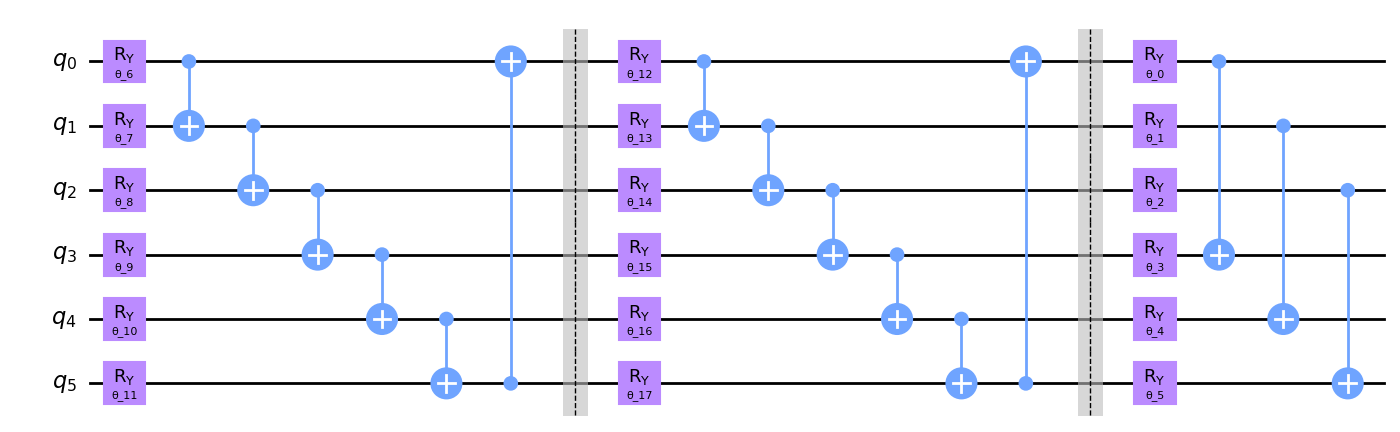

In [39]:
ansatz_review_exact(6,2).draw("mpl")

## evolution

In [64]:
depth = 4
qubits = 3
hamiltonian = Operator(np.kron(Ham(qubits,1,2),krId(qubits)))
var_principle = ImaginaryMcLachlanPrinciple()
time = 0.2
aux_ops = [hamiltonian]
init_param_values =  [np.pi/2]*qubits + [0]*(depth*qubits*2+qubits)
ansatz = ansatz_review_exact(qubits*2,depth)
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops)
var_qite = VarQITE(ansatz, init_param_values, var_principle, Estimator())
evolution_result = var_qite.evolve(evolution_problem)



In [65]:
init_state = Statevector(ansatz.assign_parameters(init_param_values))
evolution_problem = TimeEvolutionProblem(hamiltonian, time, initial_state=init_state, aux_operators=aux_ops)
exact_evol = SciPyImaginaryEvolver(num_timesteps=int(time * 100))
sol = exact_evol.evolve(evolution_problem)

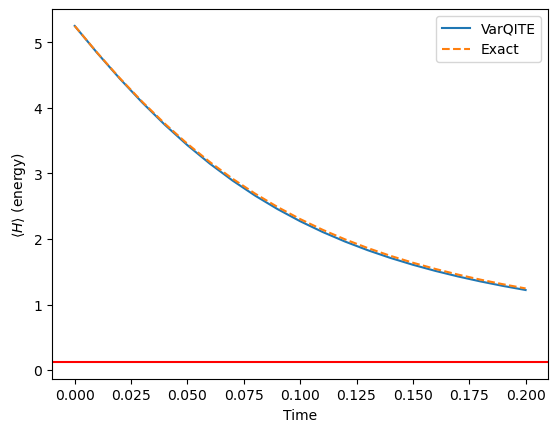

In [66]:
h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])

exact_h_exp_val = sol.observables[0][0].real

times = evolution_result.times
pylab.plot(times, h_exp_val, label= "VarQITE")
pylab.plot(times, exact_h_exp_val , label= "Exact",  linestyle='--')
plt.axhline(y=0.125, color='r', linestyle='-')
pylab.xlabel("Time")
pylab.ylabel(r"$\langle H \rangle$ (energy)")
pylab.legend(loc="upper right");

{'000': 0.32441329142697695, '001': 0.027625896299386707, '010': 0.14554386044384293, '011': 0.002416951829793479, '100': 0.145543860443843, '101': 0.002416951829793477, '110': 0.32441329142697706, '111': 0.02762589629938669}
['100', '110', '101', '111', '000', '001', '010', '011']


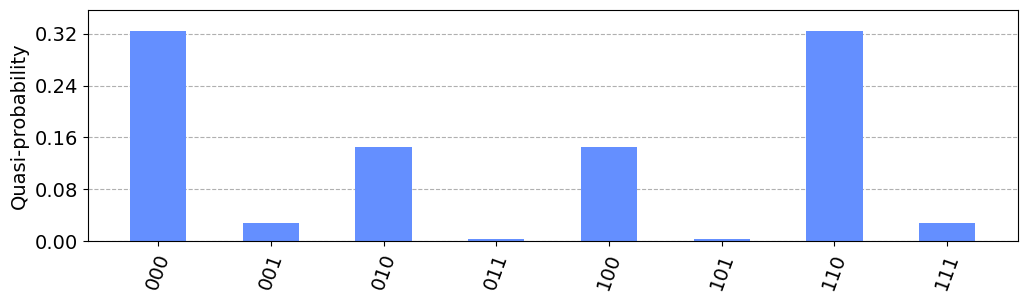

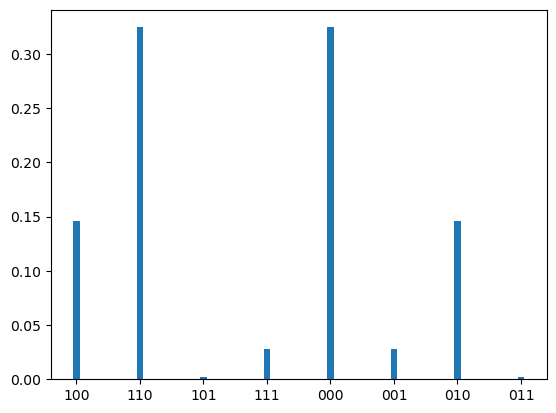

In [68]:
evolved_state = Statevector(evolution_result.evolved_state)
dict_1 = evolved_state.probabilities_dict([0,1,2])
key_order = ["111", "110","101", "100","000", "001", "010", "011" ]
lelalö = {k : dict_1[k] for k in key_order}
print(dict_1)
#print(lelalö["000"])
x=[]
for j in range(2):
    for k in range(2):
        x.append(str((1)%2)+str((k)%2)+str((j)%2))

for j in range(2):
    for k in range(2):
        x.append(str(0)+str((j) % 2)+str((k) %2 ))
print(x)

y=[]
for i in range(len(x)):
    y.append(dict_1[x[i]])

plt.bar(x, y, width=0.1)
#plt.xticks(states)
#plt.yticks(probability)
    

plot_histogram(lelalö,figsize= (12,3),sort='asc',bar_labels=False)

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=10000)
result = job.result()
counts = result.get_counts(circuit)#
plot_histogram(counts)

In [44]:
print(x,y)

['100', '000', '110', '010', '000', '010', '100', '110'] [0.13982382666265877, 0.14444295862743758, 0.14444295862743745, 0.13982382666265888, 0.14444295862743758, 0.13982382666265888, 0.13982382666265877, 0.14444295862743745]


In [50]:
len(x)

8

In [51]:
len(y)

8

In [63]:
print(1/((np.trace(np.exp(-4*Ham(2,1,2)))))*np.trace(np.exp(-4*Ham(2,1,2))*Ham(2,1,2)))

(0.25067070026093297+0j)


In [53]:
2*(1/4*np.exp(0)+9/4*np.exp(-2*(8/4)))

0.5824203749993038

In [8]:
x = [-5,-4,-3,-2,-1,0,1,2,3,4,5]
pylab.plot(x,np.exp(-x**3))


TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'